In [ ]:
!pip install kagglehub
!pip install findspark

In [ ]:
import findspark
findspark.init()
import pyspark

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rohanrao/air-quality-data-in-india")
path += "/city_day.csv"
print("Path to dataset:", path)

Path to dataset: /root/.cache/kagglehub/datasets/rohanrao/air-quality-data-in-india/versions/12/city_day.csv


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


appName = "Air Quality India"
spark = SparkSession \
.builder \
.appName(appName) \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

In [ ]:
sc = spark.sparkContext

In [ ]:
df = spark.read.options(
    delimiter=',',     # Use comma instead of semicolon
    inferSchema=True,  # Auto-detect data types
    header=True        # Use first row as column names
).csv(path)

In [ ]:
df = df.withColumnRenamed("PM2.5", "PM25")

In [ ]:
df.printSchema()

root
 |-- City: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- PM25: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Xylene: double (nullable = true)
 |-- AQI: double (nullable = true)
 |-- AQI_Bucket: string (nullable = true)



In [ ]:
df = df.dropna(how="any")

In [ ]:
df.describe().show()

+-------+-------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+----------+
|summary|         City|              PM25|              PM10|                NO|              NO2|               NOx|               NH3|                CO|               SO2|                O3|          Benzene|           Toluene|           Xylene|               AQI|AQI_Bucket|
+-------+-------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+----------+
|  count|         6236|              6236|              6236|              6236|             6236|              6236|              6236|              6236|        

In [ ]:
df.select("AQI_Bucket").distinct().show() #bombardilo crocodili

+------------+
|  AQI_Bucket|
+------------+
|        Good|
|      Severe|
|   Very Poor|
|Satisfactory|
|        Poor|
|    Moderate|
+------------+



In [ ]:
from pyspark.sql.functions import udf, rand
from pyspark.sql.types import StringType, DoubleType

In [ ]:
df = df.withColumn("NO", df["NO"].cast('double'))
df = df.withColumn("NOx", df["NOx"].cast('double'))
df = df.withColumn("NH3", df["NH3"].cast('double'))
df = df.withColumn("CO", df["CO"].cast('double'))
df = df.withColumn("SO2", df["SO2"].cast('double'))
df = df.withColumn("Benzene", df["Benzene"].cast('double'))
df = df.withColumn("Xylene", df["Xylene"].cast('double'))
df = df.withColumn("Toluene", df["Toluene"].cast('double'))
df = df.withColumn("NO2", df["NO2"].cast('double'))
df = df.withColumn("O3", df["O3"].cast('double'))
df = df.withColumn("PM10", df["PM10"].cast('double'))
df = df.withColumn("PM25", df["PM25"].cast('double'))
df = df.drop("AQI")

df.show(5)

+---------+----------+-----+------+----+-----+-----+-----+----+-----+------+-------+-------+------+----------+
|     City|      Date| PM25|  PM10|  NO|  NO2|  NOx|  NH3|  CO|  SO2|    O3|Benzene|Toluene|Xylene|AQI_Bucket|
+---------+----------+-----+------+----+-----+-----+-----+----+-----+------+-------+-------+------+----------+
|Amaravati|2017-11-25| 81.4| 124.5|1.44| 20.5|12.08|10.72|0.12|15.24|127.09|    0.2|    6.5|  0.06|  Moderate|
|Amaravati|2017-11-26|78.32|129.06|1.26| 26.0|14.85|10.28|0.14|26.96|117.44|   0.22|   7.95|  0.08|  Moderate|
|Amaravati|2017-11-27|88.76|135.32| 6.6|30.85|21.77|12.91|0.11|33.59|111.81|   0.29|   7.63|  0.12|  Moderate|
|Amaravati|2017-11-28|64.18|104.09|2.56|28.07|17.01|11.42|0.09| 19.0|138.18|   0.17|   5.02|  0.07|  Moderate|
|Amaravati|2017-11-29|72.47|114.84|5.23| 23.2|16.59|12.25|0.16|10.55|109.74|   0.21|   4.71|  0.08|  Moderate|
+---------+----------+-----+------+----+-----+-----+-----+----+-----+------+-------+-------+------+----------+
o

In [ ]:
df.printSchema()

root
 |-- City: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- PM25: double (nullable = true)
 |-- PM10: double (nullable = true)
 |-- NO: double (nullable = true)
 |-- NO2: double (nullable = true)
 |-- NOx: double (nullable = true)
 |-- NH3: double (nullable = true)
 |-- CO: double (nullable = true)
 |-- SO2: double (nullable = true)
 |-- O3: double (nullable = true)
 |-- Benzene: double (nullable = true)
 |-- Toluene: double (nullable = true)
 |-- Xylene: double (nullable = true)
 |-- AQI_Bucket: string (nullable = true)



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

def get_dummy(df, indexCol, categoricalCols, continuousCols, labelCol):
    stages = []

    # Handle categorical features if any
    if categoricalCols:
        indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid="keep") for c in categoricalCols]
        encoders = [OneHotEncoder(inputCol=f"{c}_indexed", outputCol=f"{c}_encoded") for c in categoricalCols]
        stages += indexers + encoders
        feature_cols = [f"{c}_encoded" for c in categoricalCols] + continuousCols
    else:
        feature_cols = continuousCols  # Only continuous features if no categorical columns

    # Assemble features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    stages.append(assembler)

    # Create pipeline and transform
    pipeline = Pipeline(stages=stages)
    model = pipeline.fit(df)
    transformed_df = model.transform(df)

    # Ensure label column is cast properly
    transformed_df = transformed_df.withColumn("label", col(labelCol).cast("double"))

    return transformed_df.select(indexCol, "features", "label")

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    print(data)
    return data.rdd.map(lambda r: [Vectors.dense(r[2:-1]),r[-1]]).toDF(['features','label'])

In [ ]:
transformed = transData(df)
transformed.show(5)

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|[81.4,124.5,1.44,...|Moderate|
|[78.32,129.06,1.2...|Moderate|
|[88.76,135.32,6.6...|Moderate|
|[64.18,104.09,2.5...|Moderate|
|[72.47,114.84,5.2...|Moderate|
+--------------------+--------+
only showing top 5 rows



In [ ]:
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5)

+--------------------+--------+------------+
|            features|   label|indexedLabel|
+--------------------+--------+------------+
|[81.4,124.5,1.44,...|Moderate|         0.0|
|[78.32,129.06,1.2...|Moderate|         0.0|
|[88.76,135.32,6.6...|Moderate|         0.0|
|[64.18,104.09,2.5...|Moderate|         0.0|
|[72.47,114.84,5.2...|Moderate|         0.0|
+--------------------+--------+------------+
only showing top 5 rows



In [ ]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5)

+--------------------+--------+--------------------+
|            features|   label|     indexedFeatures|
+--------------------+--------+--------------------+
|[81.4,124.5,1.44,...|Moderate|[81.4,124.5,1.44,...|
|[78.32,129.06,1.2...|Moderate|[78.32,129.06,1.2...|
|[88.76,135.32,6.6...|Moderate|[88.76,135.32,6.6...|
|[64.18,104.09,2.5...|Moderate|[64.18,104.09,2.5...|
|[72.47,114.84,5.2...|Moderate|[72.47,114.84,5.2...|
+--------------------+--------+--------------------+
only showing top 5 rows



In [ ]:
(trainingData, testData) = transformed.randomSplit([0.8, 0.2])

trainingData.show(5)
testData.show(5)

+--------------------+------------+
|            features|       label|
+--------------------+------------+
|[4.65,12.76,1.48,...|        Good|
|[4.7,12.83,1.66,1...|        Good|
|[5.08,8.16,13.55,...|Satisfactory|
|[5.29,17.65,6.04,...|Satisfactory|
|[5.56,11.67,8.02,...|        Good|
+--------------------+------------+
only showing top 5 rows

+--------------------+------------+
|            features|       label|
+--------------------+------------+
|[2.0,17.99,1.29,1...|        Good|
|[7.0,7.8,1.7,7.66...|Satisfactory|
|[7.3,32.25,3.85,6...|        Good|
|[7.45,20.5,3.99,8...|Satisfactory|
|[7.53,24.18,2.74,...|        Good|
+--------------------+------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='indexedFeatures', labelCol='indexedLabel')

In [ ]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [ ]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

In [ ]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [ ]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------------+--------------+
|            features|       label|predictedLabel|
+--------------------+------------+--------------+
|[2.0,17.99,1.29,1...|        Good|          Good|
|[7.0,7.8,1.7,7.66...|Satisfactory|          Good|
|[7.3,32.25,3.85,6...|        Good|          Good|
|[7.45,20.5,3.99,8...|Satisfactory|          Good|
|[7.53,24.18,2.74,...|        Good|          Good|
+--------------------+------------+--------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.230059


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_temp

['Moderate', 'Satisfactory', 'Poor', 'Good', 'Very Poor', 'Severe']

In [ ]:
predictions.show(5)

+--------------------+------------+------------+--------------------+--------------------+--------------------+----------+--------------+
|            features|       label|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+------------+------------+--------------------+--------------------+--------------------+----------+--------------+
|[2.0,17.99,1.29,1...|        Good|         3.0|[2.0,17.99,1.29,1...|[0.24151765690502...|[0.01207588284525...|       3.0|          Good|
|[7.0,7.8,1.7,7.66...|Satisfactory|         1.0|[7.0,7.8,1.7,7.66...|[0.99054556849496...|[0.04952727842474...|       3.0|          Good|
|[7.3,32.25,3.85,6...|        Good|         3.0|[7.3,32.25,3.85,6...|[0.23577776525532...|[0.01178888826276...|       3.0|          Good|
|[7.45,20.5,3.99,8...|Satisfactory|         1.0|[7.45,20.5,3.99,8...|[0.58030689062143...|[0.02901534453107...|       3.0|          Good|
|[7.53,24.18,2.74,...|        Good

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[414,  53,  18,   0,   1,   0],
       [ 68, 340,   0,   7,   0,   0],
       [ 32,   2,  62,   0,  23,   0],
       [  0,  48,   0,  39,   0,   0],
       [  0,   0,   9,   0,  50,   5],
       [  1,   0,   0,   0,   7,  12]])

Confusion matrix, without normalization
[[414  53  18   0   1   0]
 [ 68 340   0   7   0   0]
 [ 32   2  62   0  23   0]
 [  0  48   0  39   0   0]
 [  0   0   9   0  50   5]
 [  1   0   0   0   7  12]]


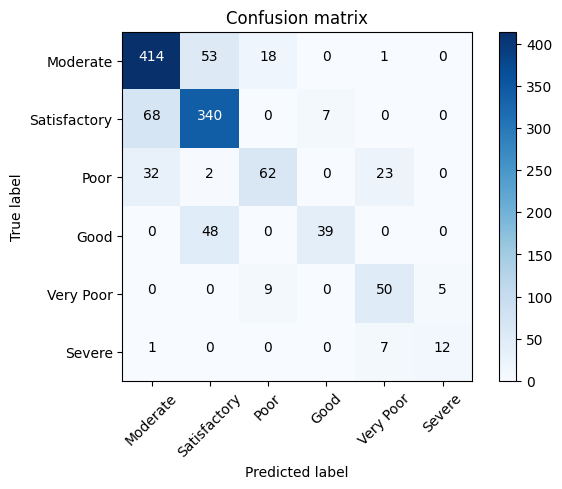

In [ ]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix')
plt.show()

In [ ]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Define Hyperparameter Grid
paramGrid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 50, 100])  # Number of trees in forest
    .addGrid(rf.maxDepth, [5, 10, 15])  # Depth of each tree
    .addGrid(rf.maxBins, [32, 64])  # Number of bins for split calculations
    .addGrid(rf.minInstancesPerNode, [1, 2, 5])  # Minimum instances per node
    .build()
)

# Define Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", metricName="accuracy")

# Cross Validator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Train Model with Cross Validation
cvModel = cv.fit(trainingData)

# Get Best Model
bestModel = cvModel.bestModel
print("Best Parameters Found:")
print("Best numTrees:", bestModel.stages[2].getNumTrees)
print("Best maxDepth:", bestModel.stages[2].getMaxDepth)

Best Parameters Found:
Best numTrees: 100
Best maxDepth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_e95fce73af7d, numTrees=100, numClasses=6, numFeatures=12>


In [ ]:
predictions = bestModel.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------------+--------------+
|            features|       label|predictedLabel|
+--------------------+------------+--------------+
|[2.0,17.99,1.29,1...|        Good|          Good|
|[7.0,7.8,1.7,7.66...|Satisfactory|  Satisfactory|
|[7.3,32.25,3.85,6...|        Good|          Good|
|[7.45,20.5,3.99,8...|Satisfactory|  Satisfactory|
|[7.53,24.18,2.74,...|        Good|          Good|
+--------------------+------------+--------------+
only showing top 5 rows



In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.178002


In [ ]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[422,  41,  23,   0,   0,   0],
       [ 62, 341,   0,  12,   0,   0],
       [ 19,   1,  87,   0,  12,   0],
       [  0,  22,   0,  65,   0,   0],
       [  0,   0,  11,   0,  50,   3],
       [  1,   0,   0,   0,   5,  14]])

Confusion matrix, without normalization
[[422  41  23   0   0   0]
 [ 62 341   0  12   0   0]
 [ 19   1  87   0  12   0]
 [  0  22   0  65   0   0]
 [  0   0  11   0  50   3]
 [  1   0   0   0   5  14]]


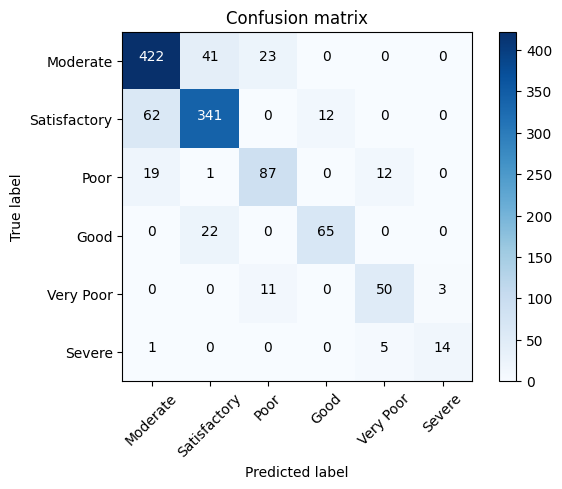

In [ ]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix')
plt.show()